In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

2025-03-25 08:39:49.138116: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-25 08:39:49.147911: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742888389.160732  121873 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742888389.164453  121873 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742888389.174027  121873 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
df = pd.read_csv("../../data/contaminated/anomalieChatGpt.csv")
print("Total d'exemples :", len(df))
print(df['anomalous'].value_counts(), "\n")

Total d'exemples : 3419
anomalous
0    3077
1     342
Name: count, dtype: int64 



In [3]:
sbert_model =SentenceTransformer('paraphrase-MiniLM-L6-v2')
texts = df['modified_text'].tolist()
embeddings = sbert_model.encode(texts,batch_size=32,show_progress_bar=True)
print("Dimensions des embeddings :", embeddings.shape)


Batches:   0%|          | 0/107 [00:00<?, ?it/s]

Dimensions des embeddings : (3419, 384)


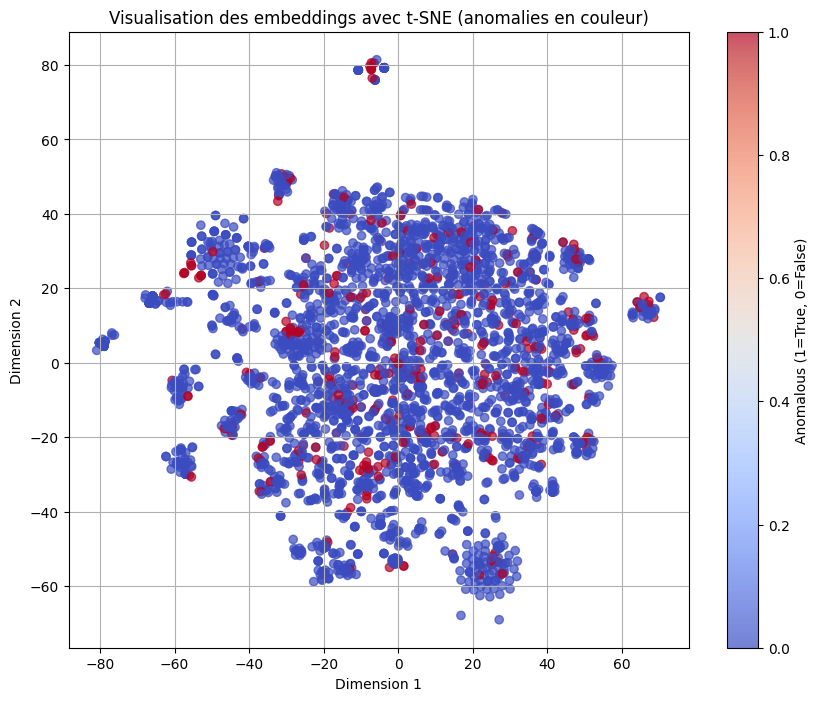

In [4]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne = TSNE(n_components=2, random_state=42)
reduced_2d = tsne.fit_transform(embeddings)

# Visualisation
plt.figure(figsize=(10, 8))
plt.scatter(
    reduced_2d[:, 0],
    reduced_2d[:, 1],
    c=df["anomalous"],
    cmap='coolwarm',
    alpha=0.7
)
plt.title('Visualisation des embeddings avec t-SNE (anomalies en couleur)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar(label='Anomalous (1=True, 0=False)')
plt.grid(True)
plt.show()


In [5]:
y_true = df['anomalous'].values
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, y_true, test_size=0.2, random_state=42, stratify=y_true
)
print("Taille train :", X_train.shape[0], " - Taille test :", X_test.shape[0])

Taille train : 2735  - Taille test : 684


In [6]:
# Pour l'Autoencodeur et One-Class SVM, on entraînera uniquement sur les données normales
X_train_normal = X_train[y_train == 0]

In [7]:
contamination = 0.10  # On attend environ 10% d'anomalies dans le train
iforest = IsolationForest(n_estimators=100, contamination=contamination, random_state=42)
iforest.fit(X_train)

IsolationForest(contamination=0.1, random_state=42)

In [8]:
scores_if_test = iforest.decision_function(X_test)
thresh_if = np.percentile(iforest.decision_function(X_train), 100 * contamination)
# Prédiction : on considère comme anomalie si le score est inférieur au seuil
y_pred_if = (scores_if_test < thresh_if).astype(int)
print("Isolation Forest - anomalies détectées sur test :", y_pred_if.sum())


Isolation Forest - anomalies détectées sur test : 82


In [9]:
ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.10)
ocsvm.fit(X_train_normal)
scores_oc_test = ocsvm.decision_function(X_test)
scores_oc_train = ocsvm.decision_function(X_train_normal)
thresh_oc = np.percentile(scores_oc_train, 100 * 0.10)
# Prédiction : anomalie si le score est inférieur au seuil
y_pred_oc = (scores_oc_test < thresh_oc).astype(int)
print("One-Class SVM - anomalies détectées sur test :", y_pred_oc.sum())

''' = OneClassSVM(kernel='rbf', gamma='scale', nu=0.10)
# Entraînement uniquement sur les données normales du train
ocsvm.fit(X_train_normal)
# Obtenir les scores sur le test
scores_oc_test = ocsvm.decision_function(X_test)
# Calculer les scores sur les données normales du train
scores_oc_train = ocsvm.decision_function(X_train_normal)
# Définir le seuil au 95ᵉ percentile
thresh_oc = np.percentile(scores_oc_train, 95)
# Prédiction : anomalie si le score est inférieur au seuil
y_pred_oc = (scores_oc_test < thresh_oc).astype(int)
print("One-Class SVM - anomalies détectées sur test :", y_pred_oc.sum())'''



One-Class SVM - anomalies détectées sur test : 69


' = OneClassSVM(kernel=\'rbf\', gamma=\'scale\', nu=0.10)\n# Entraînement uniquement sur les données normales du train\nocsvm.fit(X_train_normal)\n# Obtenir les scores sur le test\nscores_oc_test = ocsvm.decision_function(X_test)\n# Calculer les scores sur les données normales du train\nscores_oc_train = ocsvm.decision_function(X_train_normal)\n# Définir le seuil au 95ᵉ percentile\nthresh_oc = np.percentile(scores_oc_train, 95)\n# Prédiction : anomalie si le score est inférieur au seuil\ny_pred_oc = (scores_oc_test < thresh_oc).astype(int)\nprint("One-Class SVM - anomalies détectées sur test :", y_pred_oc.sum())'

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
X_train_normal_tensor = torch.tensor(X_train_normal, dtype=torch.float32)
dataset = TensorDataset(X_train_normal_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
input_dim = X_train_normal_tensor.shape[1]
model = Autoencoder(input_dim=input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 50
model.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch in dataloader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * inputs.size(0)
    avg_loss = total_loss / len(dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
model.eval()
with torch.no_grad():
    recon_test = model(X_test_tensor)

errors_test = ((recon_test - X_test_tensor)**2).mean(dim=1).numpy()

scores_ae_test = -errors_test

with torch.no_grad():
    recon_train = model(X_train_normal_tensor)
errors_train = ((recon_train - X_train_normal_tensor)**2).mean(dim=1).numpy()
thresh_ae = np.percentile(errors_train, 95)  # Seuil = 95e percentile

y_pred_ae = (errors_test > thresh_ae).astype(int)
print("Autoencodeur - anomalies détectées sur test :", y_pred_ae.sum())

precision_ae = precision_score(y_test, y_pred_ae)
recall_ae = recall_score(y_test, y_pred_ae)
f1_ae = f1_score(y_test, y_pred_ae)
roc_auc_ae = roc_auc_score(y_test, scores_ae_test)

print("Autoencodeur - Précision: {:.2f}, Rappel: {:.2f}, F1-score: {:.2f}, ROC AUC: {:.2f}".format(
    precision_ae, recall_ae, f1_ae, roc_auc_ae))


Epoch 1/50, Loss: 0.0294
Epoch 2/50, Loss: 0.0171
Epoch 3/50, Loss: 0.0132
Epoch 4/50, Loss: 0.0111
Epoch 5/50, Loss: 0.0099
Epoch 6/50, Loss: 0.0091
Epoch 7/50, Loss: 0.0084
Epoch 8/50, Loss: 0.0079
Epoch 9/50, Loss: 0.0075
Epoch 10/50, Loss: 0.0072
Epoch 11/50, Loss: 0.0070
Epoch 12/50, Loss: 0.0068
Epoch 13/50, Loss: 0.0066
Epoch 14/50, Loss: 0.0064
Epoch 15/50, Loss: 0.0063
Epoch 16/50, Loss: 0.0062
Epoch 17/50, Loss: 0.0062
Epoch 18/50, Loss: 0.0061
Epoch 19/50, Loss: 0.0061
Epoch 20/50, Loss: 0.0060
Epoch 21/50, Loss: 0.0060
Epoch 22/50, Loss: 0.0059
Epoch 23/50, Loss: 0.0059
Epoch 24/50, Loss: 0.0059
Epoch 25/50, Loss: 0.0059
Epoch 26/50, Loss: 0.0059
Epoch 27/50, Loss: 0.0059
Epoch 28/50, Loss: 0.0058
Epoch 29/50, Loss: 0.0058
Epoch 30/50, Loss: 0.0058
Epoch 31/50, Loss: 0.0058
Epoch 32/50, Loss: 0.0057
Epoch 33/50, Loss: 0.0057
Epoch 34/50, Loss: 0.0057
Epoch 35/50, Loss: 0.0057
Epoch 36/50, Loss: 0.0057
Epoch 37/50, Loss: 0.0057
Epoch 38/50, Loss: 0.0057
Epoch 39/50, Loss: 0.

In [11]:
# --- 7. Évaluation des performances ---
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Isolation Forest
precision_if = precision_score(y_test, y_pred_if)
recall_if    = recall_score(y_test, y_pred_if)
f1_if        = f1_score(y_test, y_pred_if)
roc_auc_if   = roc_auc_score(y_test, scores_if_test)

# One-Class SVM
precision_oc = precision_score(y_test, y_pred_oc)
recall_oc    = recall_score(y_test, y_pred_oc)
f1_oc        = f1_score(y_test, y_pred_oc)
roc_auc_oc   = roc_auc_score(y_test, scores_oc_test)


In [12]:
results = pd.DataFrame({
    "Modèle": ["Isolation Forest", "Autoencodeur", "One-Class SVM"],
    "Précision": [precision_if, precision_ae, precision_oc],
    "Rappel": [recall_if, recall_ae, recall_oc],
    "F1-score": [f1_if, f1_ae, f1_oc],
    "ROC AUC": [roc_auc_if, roc_auc_ae, roc_auc_oc]
}) 

print("\nTableau récapitulatif des performances :")
print(results)


Tableau récapitulatif des performances :
             Modèle  Précision    Rappel  F1-score   ROC AUC
0  Isolation Forest   0.000000  0.000000  0.000000  0.600506
1      Autoencodeur   0.048387  0.044118  0.046154  0.441940
2     One-Class SVM   0.028986  0.029412  0.029197  0.685041


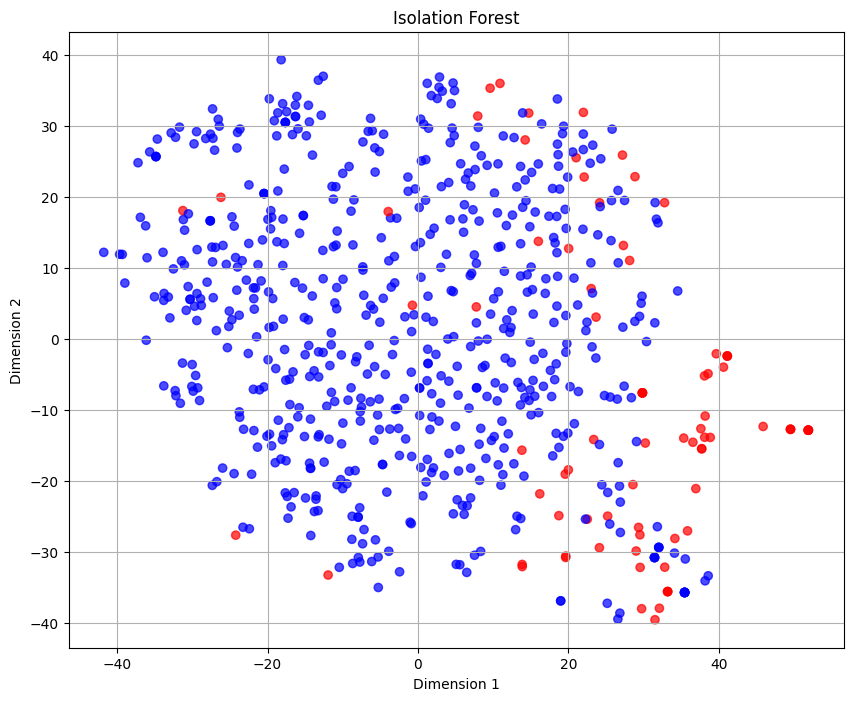

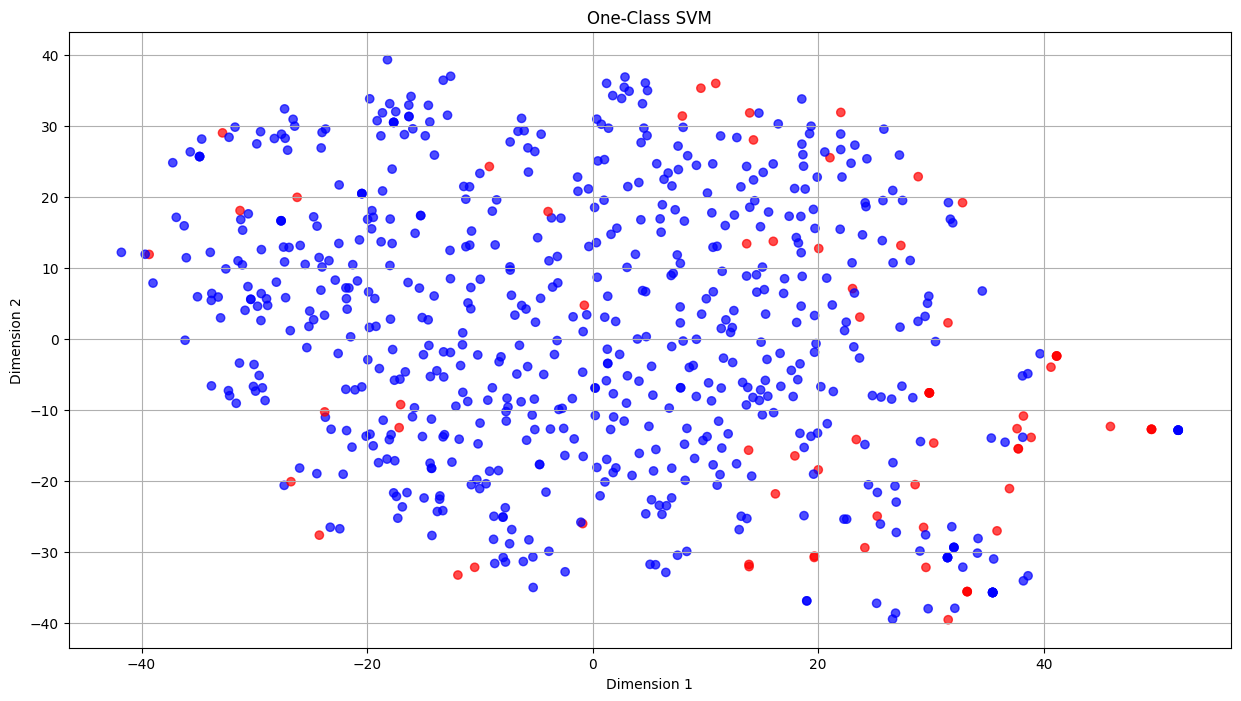

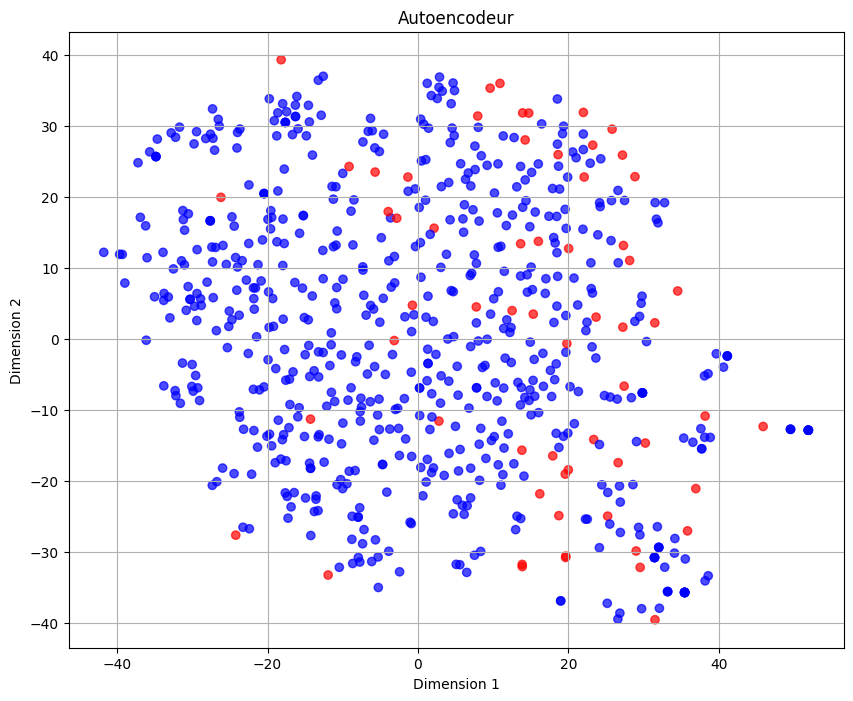

In [13]:
tsne = TSNE(n_components=2, random_state=42)
X_test_2d = tsne.fit_transform(X_test)

# --- Visualisation pour Isolation Forest ---
plt.figure(figsize=(10, 8))
colors_if = np.where(y_pred_if == 1, 'red', 'blue')
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=colors_if, alpha=0.7)
plt.title('Isolation Forest')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

# --- Visualisation pour One-Class SVM ---
plt.figure(figsize=(15, 8))
colors_oc = np.where(y_pred_oc == 1, 'red', 'blue')
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=colors_oc, alpha=0.7)
plt.title('One-Class SVM')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

# --- Visualisation pour l'Autoencodeur ---
plt.figure(figsize=(10, 8))
colors_ae = np.where(y_pred_ae == 1, 'red', 'blue')
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=colors_ae, alpha=0.7)
plt.title('Autoencodeur')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()